# Regressione lineare multipla

## Ottenimento del dataset

<ipython-input-68-f3a5467b46fa>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-whitegrid')


Contenuto del DataFrame:
   UserID  Age  Gender       VRHeadset   Duration  MotionSickness  \
0       1   40       2        HTC Vive  13.598508               8   
1       2   43       1        HTC Vive  19.950815               2   
2       3   27       2  PlayStation VR  16.543387               4   
3       4   33       2        HTC Vive  42.574083               6   
4       5   51       2  PlayStation VR  22.452647               4   

   ImmersionLevel  
0               5  
1               2  
2               2  
3               3  
4               2  


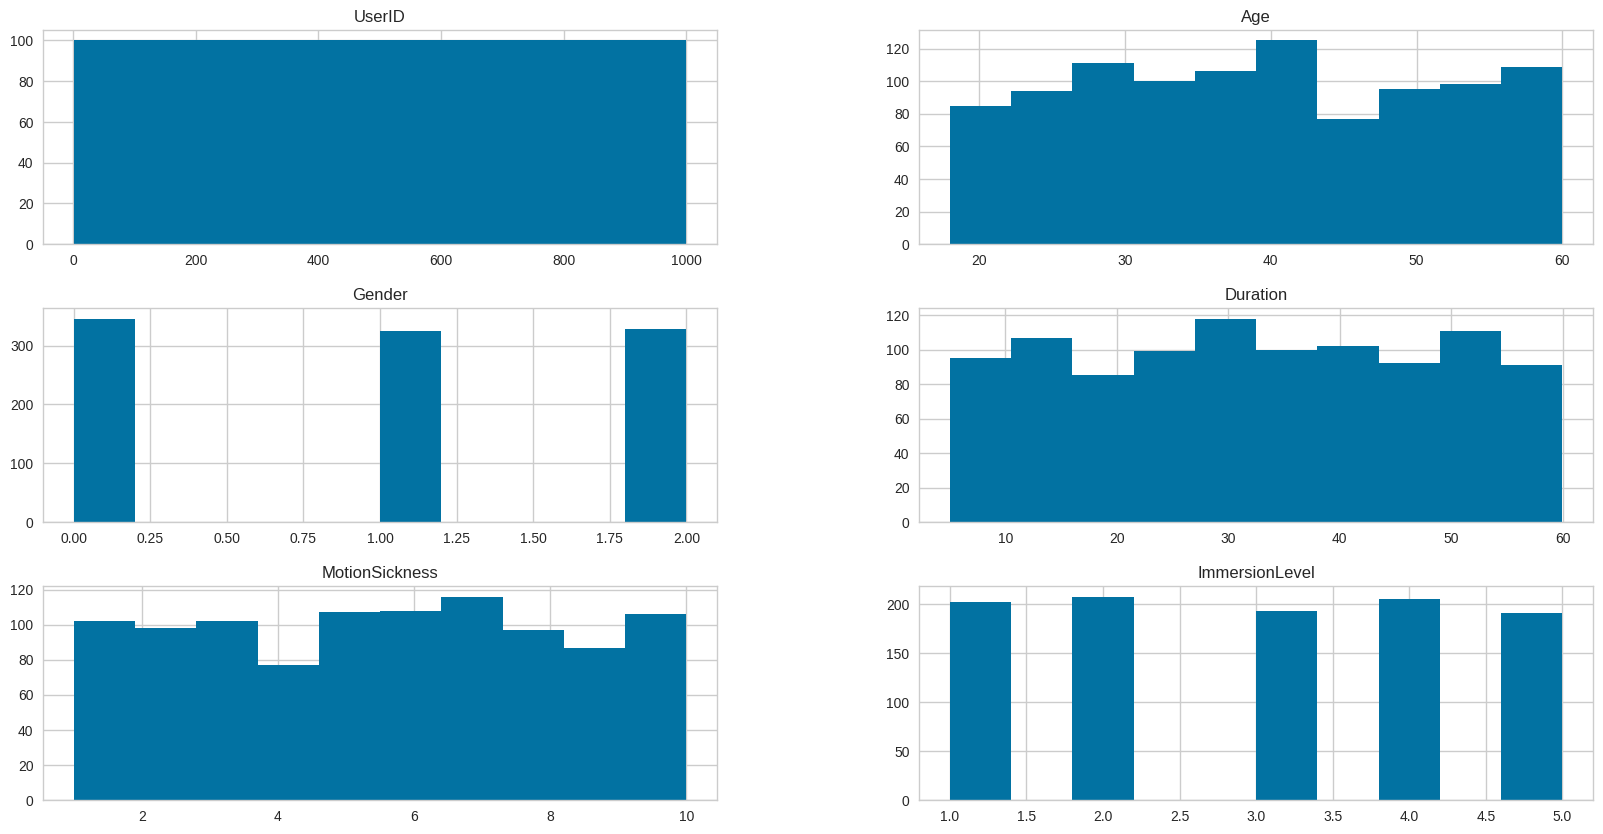

In [68]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from six.moves import urllib
import seaborn as sb
from matplotlib import style

style.use('seaborn-whitegrid')

plt.rcParams['figure.figsize'] = (20, 10)

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/everysimo/MetaClass_IA_Meeting/master/data.csv"
FILE_PATH = "file"
FILE_NAME = "data.csv"
CSV_PATH = os.path.join(FILE_PATH, FILE_NAME)

# fetch dataset da github
def fetch_file_data1(file_url=DOWNLOAD_ROOT, file_path=FILE_PATH, file_name=FILE_NAME):
    os.makedirs(file_path, exist_ok=True)
    csv_path = os.path.join(file_path, file_name)
    urllib.request.urlretrieve(file_url, csv_path)

fetch_file_data1()

# Verifica il contenuto del file scaricato
try:
    df = pd.read_csv(CSV_PATH)
    print("Contenuto del DataFrame:")
    print(df.head())
    # Visualizza l'istogramma
    df.hist()
    plt.show()
except pd.errors.EmptyDataError:
    print("Il file CSV è vuoto.")
except pd.errors.ParserError:
    print("Errore di parsing del file CSV.")
except Exception as e:
    print(f"Errore sconosciuto: {e}")


## 1)DataCleaning

### 1.1) Descrizione del dataset

In [69]:
#descrizione dataset
df.describe()

,UserID,Age,Gender,Duration,MotionSickness,ImmersionLevel
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,39.178000,0.983000,32.576660,5.526000,2.976000
std,288.819436,12.050208,0.821819,15.764659,2.866625,1.409756
min,1.000000,18.000000,0.000000,5.008672,1.000000,1.000000
25%,250.750000,29.000000,0.000000,18.733748,3.000000,2.000000
50%,500.500000,39.000000,1.000000,32.368611,6.000000,3.000000
75%,750.250000,49.000000,2.000000,45.343732,8.000000,4.000000
max,1000.000000,60.000000,2.000000,59.983723,10.000000,5.000000


### 1.2) Verifica valori null nel dataset

In [70]:
#verifica se ci sono dati null nel dataset
df.isnull().any()

UserID            False
Age               False
Gender            False
VRHeadset         False
Duration          False
MotionSickness    False
ImmersionLevel    False
dtype: bool

### 1.3) Verifica valori N/A nel dataset

In [71]:
#verifica se ci sono dati NA nel dataset
df.isna().any()

UserID            False
Age               False
Gender            False
VRHeadset         False
Duration          False
MotionSickness    False
ImmersionLevel    False
dtype: bool

###1.4) Data Plot

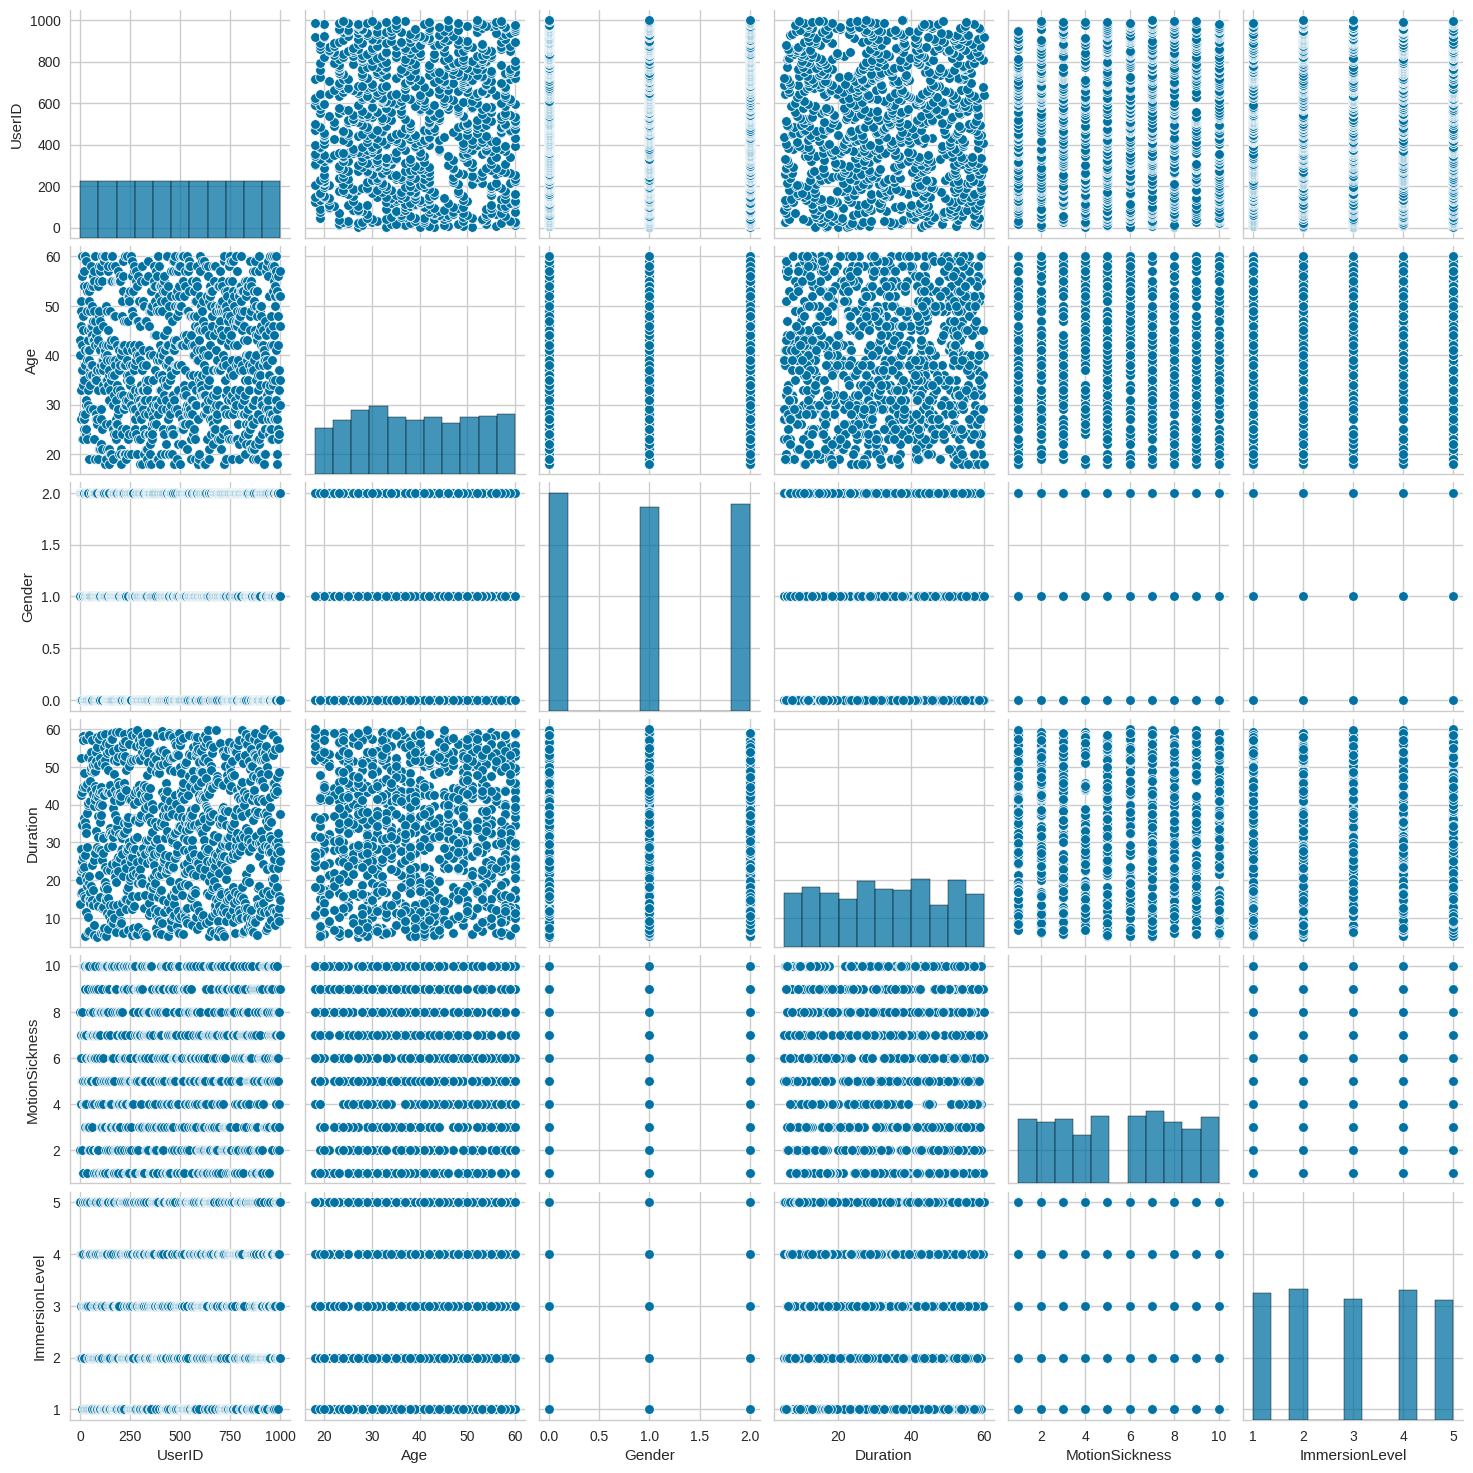

In [72]:
#data plot visualizzare dipendenze tra variabili
sb.pairplot(df)
#salvataggio plot
plt.savefig('pairplor.png')

###1.5) Plot Linearità e Multicollinearità

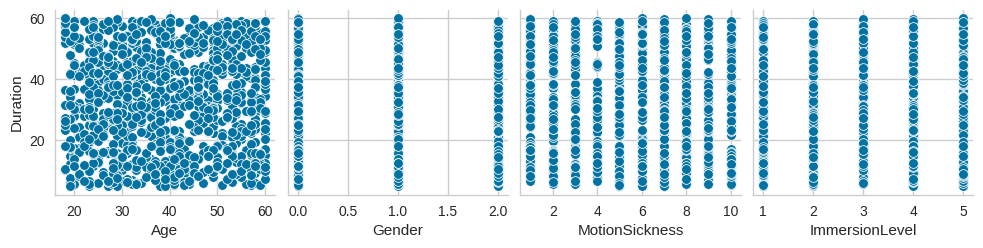

In [73]:
#Data plot su un sottoinsieme preso in esame
sb.pairplot(df,x_vars=["Age","Gender", "MotionSickness", "ImmersionLevel"], y_vars=["Duration"])
#salvataggio linear plot
plt.savefig('linearPlot.png')

<ipython-input-74-ea2f41bc6710>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), annot=True, cmap="RdYlGn", square=True)


<Axes: >

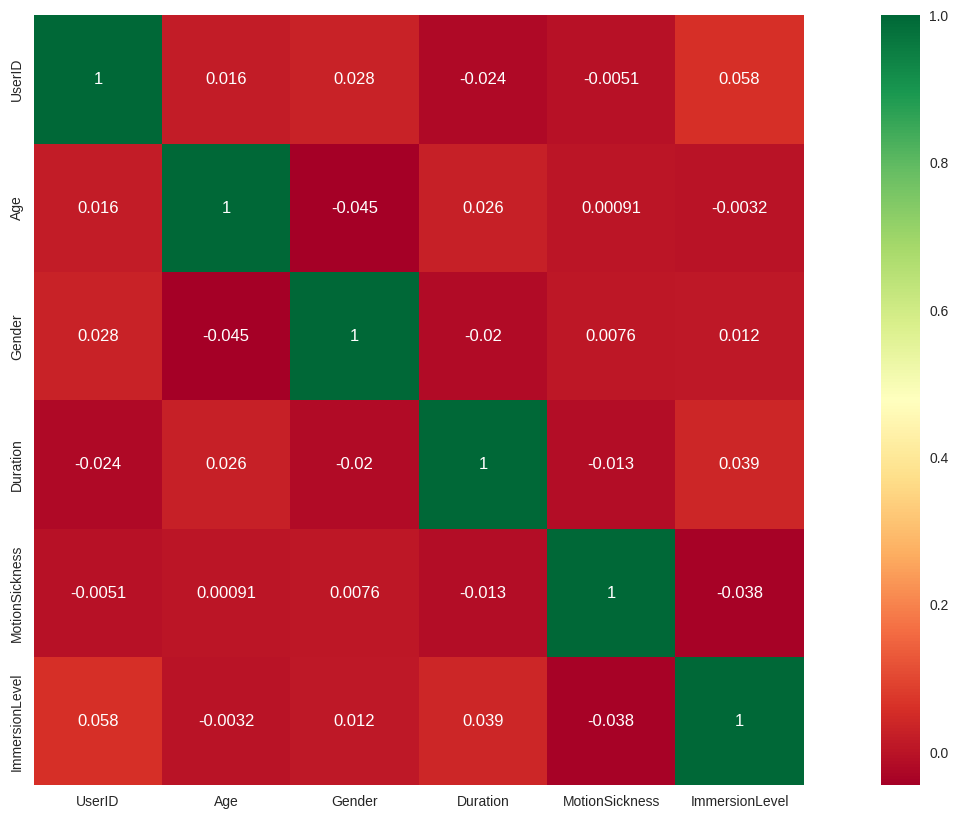

In [74]:
#correlazione tra le variabili
sb.heatmap(df.corr(), annot=True, cmap="RdYlGn", square=True)

## 2)Divisione in Training e Test Sets, Feature Selection

###2.1) Definizione classe Metrics

In [75]:
#oggetto che contiene le metriche
class Metrics1:
  #costruttore
  def __init__(self,mae,mse,rmse):
    self.mae=mae
    self.mse=mse
    self.rmse=rmse

  #ToString
  def __str__(self):
    return f'Metrics [mae= {self.mae} mse= {self.mse} rmse= {self.rmse} mean= {np.mean([self.mae,self.mse,self.rmse])}'

###2.2) Definizione classe MetricsResultContainer

In [76]:
#classe per contenere risultato delle metriche
class MetricsResultContainer:
  meanMAE = []
  meanMSE = []
  meanRMSE = []
  #costruttore
  def __init__(self,model,alg,scaler,param,metricsMean):
    self.model=model
    self.alg=alg
    self.scaler=scaler
    self.param=param
    self.metricsMean=metricsMean
    self.meanMAE = []
    self.meanMSE = []
    self.meanRMSE = []
  #funzione per stampare metriche
  def printMetrics(self):
    for m in self.metricsMean:
      self.meanMAE.append(m.mae)
      self.meanMSE.append(m.mse)
      self.meanRMSE.append(m.rmse)
    print("meanMAE=",np.mean(self.meanMAE))
    print("meanMSE=",np.mean(self.meanMSE))
    print("meanRMSE=",np.mean(self.meanRMSE))

### 2.3) Istanziazione funzioni per Regressione

In [93]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_regression
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.base import clone

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.base import Visualizer

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip

from termcolor import colored as cl

#funzione per generare il modello, divisione training e test, features scaling, selection
def generateModel(alg, scaler, model, select):
  #array di metriche (MAE,MSE,RMSE)
  metrics1 = []
  #generazione n_split test/trainig sets
  #uso algoritmo per dividere i dati di raining da quelli di test
  for train_index, test_index in alg.split(X,y):
    clone_model = clone(model)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #feature scaling sui traing test
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)
    #applicazione feature selection su train_z
    X_train_z = select.fit_transform(X_train_z, y_train)
    X_test_z = select.transform(X_test_z)

    #training dell'algoritmo sui training set
    clone_model.fit(X_train_z,y_train)
    #validazione modello e applicazione predizione sui testSet
    y_pred = clone_model.predict(X_test_z)
    modelCopy = copy.copy(clone_model)
    #calcolo metriche predizione
    metrics1.append(
        Metrics1(metrics.mean_absolute_error(y_test,y_pred),
                 metrics.mean_squared_error(y_test,y_pred),
                 np.sqrt(metrics.mean_squared_error(y_test,y_pred))
                 )
        )
  return metrics1

#Scelta variabile dipendente (y) e indipendenti (X)
X=df.drop(columns=['Duration','VRHeadset',"UserID"])
y=df.Duration
#numero record nel dataset
k=len(df)
#calcolo k ideale da usare nelle tecniche di validazione deve essere il 30% della lunghezza del dataset
k= (k/(k*0.3))
#Kf divisione dataset per k gruppi per testare mediante due algoritmi Kfold-RepeateKFold
kf = KFold(n_splits=int(np.ceil(k)),random_state=42, shuffle=True)
#rKf con k gruppi, e 10 ripetizioni
rkf = RepeatedKFold(n_splits=int(np.ceil(k)), n_repeats=100, random_state=42)
#rkf con 3 gruppi e 10 ripetizioni per questioni  di utilizzo della ram messa a disposizione da google
rkfRF = RepeatedKFold(n_splits=3, n_repeats=10, random_state=42)
#instanziazione algritmo per selezione dei KBest individui
select = SelectKBest(f_regression, k=4)
#risultati: array di array di metriche
metricsResults = []

## 3) Model Testing

### 3.1) Linear Regression

In [94]:
from sklearn.linear_model import LinearRegression
#Linear Regression
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e KFold
print("Linear Regression - ZScore Normalization - KF")
m = MetricsResultContainer("Linear Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e RKFold
print("\nLinear Regression - ZScore Normalization - RKF")
m = MetricsResultContainer("Linear Regression","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero Minimax e KFold
print("\nLinear Regression - MinMax Normalization - KF")
m = MetricsResultContainer("Linear Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero Minmax e RKFold
print("\nLinear Regression - MinMax Normalization - RKF")
m = MetricsResultContainer("Linear Regression","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero RobustScaler e KFold
print("\nLinear Regression - RobustScaler Normalization - KF")
m = MetricsResultContainer("Linear Regression","KF","RobustScaler","Default",
  generateModel(kf, RobustScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero RobustScaler e RKFold
print("\nLinear Regression - RobustScaler Normalization - RKF")
m = MetricsResultContainer("Linear Regression","RKF","RobustScaler","Default",
  generateModel(rkf, RobustScaler(), LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()

Linear Regression - ZScore Normalization - KF
meanMAE= 13.622985564569529
meanMSE= 249.80359305503552
meanRMSE= 15.800181038007418

Linear Regression - ZScore Normalization - RKF
meanMAE= 13.634142945346818
meanMSE= 250.36006039096523
meanRMSE= 15.816827963496912

Linear Regression - MinMax Normalization - KF
meanMAE= 13.622985564569529
meanMSE= 249.80359305503552
meanRMSE= 15.800181038007418

Linear Regression - MinMax Normalization - RKF
meanMAE= 13.634142945346817
meanMSE= 250.36006039096523
meanRMSE= 15.816827963496912

Linear Regression - RobustScaler Normalization - KF
meanMAE= 13.622985564569529
meanMSE= 249.80359305503552
meanRMSE= 15.800181038007418

Linear Regression - RobustScaler Normalization - RKF
meanMAE= 13.634142945346818
meanMSE= 250.36006039096523
meanRMSE= 15.816827963496912


### 3.2) DecisionTree Regression

In [95]:
#utilizziamo DecisionTree Regression
from sklearn.tree import DecisionTreeRegressor
print("DecisionTreeRegressor - ZScore Normalization - KF")
m = MetricsResultContainer("DecisionTree Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e KFold
m.printMetrics()

print("\nDecisionTreeRegressor - ZScore Normalization - RKF")
m = MetricsResultContainer("DecisionTree Regression","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e RKFold
m.printMetrics()

print("\nDecisionTreeRegressor - MinMax Normalization - KF")
m = MetricsResultContainer("DecisionTree Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero Minimax e KFold
m.printMetrics()

print("\nDecisionTreeRegressor - MinMax Normalization - RKF")
m = MetricsResultContainer("DecisionTree Regression","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero Minmax e RKFold
m.printMetrics()

print("\nDecisionTreeRegressor - RobustScaler Normalization - KF")
m = MetricsResultContainer("DecisionTree Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero RobustScaler e KFold
m.printMetrics()

print("\nDecisionTreeRegressor - RobustScaler Normalization - RKF")
m = MetricsResultContainer("DecisionTree Regression","RKF","Robust","Default",
  generateModel(rkf, RobustScaler(), DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero RobustScaler e RKFold
m.printMetrics()

DecisionTreeRegressor - ZScore Normalization - KF
meanMAE= 19.08320710941944
meanMSE= 519.7513289757337
meanRMSE= 22.792841965028572

DecisionTreeRegressor - ZScore Normalization - RKF
meanMAE= 18.590611724815616
meanMSE= 509.6496943264886
meanRMSE= 22.56401152721258

DecisionTreeRegressor - MinMax Normalization - KF
meanMAE= 19.059202974973417
meanMSE= 519.2594489566313
meanRMSE= 22.780672612690676

DecisionTreeRegressor - MinMax Normalization - RKF
meanMAE= 18.600184596462977
meanMSE= 509.73992679668925
meanRMSE= 22.565707739678672

DecisionTreeRegressor - RobustScaler Normalization - KF
meanMAE= 19.14611375120657
meanMSE= 521.8168050552173
meanRMSE= 22.839176905300924

DecisionTreeRegressor - RobustScaler Normalization - RKF
meanMAE= 18.560869170243382
meanMSE= 508.33426954818555
meanRMSE= 22.535049689196175


### 3.3) Lasso Regression

In [96]:
#Utilizzo Lasso regression
from sklearn import linear_model
lassoReg = linear_model.Lasso()
print("Lasso Regression - ZScore Normalization - KF")
m = MetricsResultContainer("Lasso Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - ZScore Normalization - RKF")
m = MetricsResultContainer("Lasso Regression","RKF","ZScore","Default",
  generateModel(rkfRF, StandardScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - MinMax Normalization - KF")
m = MetricsResultContainer("Lasso Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - MinMax Normalization - RKF")
m = MetricsResultContainer("Lasso Regression","RKF","MinMax","Default",
  generateModel(rkfRF, MinMaxScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - RobustScaler Normalization - KF")
m = MetricsResultContainer("Lasso Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - RobustScaler Normalization - RKF")
m = MetricsResultContainer("Lasso Regression","RKF","Robust","Default",
  generateModel(rkfRF, RobustScaler(), lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()


Lasso Regression - ZScore Normalization - KF
meanMAE= 13.59636270621059
meanMSE= 248.96056850521182
meanRMSE= 15.773057972594488

Lasso Regression - ZScore Normalization - RKF
meanMAE= 13.591765359099913
meanMSE= 248.80255253460302
meanRMSE= 15.770766940779303

Lasso Regression - MinMax Normalization - KF
meanMAE= 13.59636270621059
meanMSE= 248.96056850521182
meanRMSE= 15.773057972594488

Lasso Regression - MinMax Normalization - RKF
meanMAE= 13.591523956925153
meanMSE= 248.79603324590443
meanRMSE= 15.770556928532544

Lasso Regression - RobustScaler Normalization - KF
meanMAE= 13.59636270621059
meanMSE= 248.96056850521182
meanRMSE= 15.773057972594488

Lasso Regression - RobustScaler Normalization - RKF
meanMAE= 13.591523956925153
meanMSE= 248.79603324590443
meanRMSE= 15.770556928532544


### 3.4) Ridge Regression

In [97]:
#Utilizzo Ridge Regression
from sklearn import linear_model
bridgeReg = linear_model.Ridge()
print("Ridge Regression - ZScore Normalization - KF")
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e KFold
m = MetricsResultContainer("Ridge Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()


print("\nRidge Regression - ZScore Normalization - RKF")
m = MetricsResultContainer("Ridge Regression","RKF","ZScore","Default",
  generateModel(rkfRF, StandardScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - MinMax Normalization - KF")
m = MetricsResultContainer("Ridge Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - MinMax Normalization - RKF")
m = MetricsResultContainer("Ridge Regression","RKF","MinMax","Default",
  generateModel(rkfRF, MinMaxScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - RobustScaler Normalization - KF")
m = MetricsResultContainer("Ridge Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - RobustScaler Normalization - RKF")
m = MetricsResultContainer("Ridge Regression","RKF","Robust","Default",
  generateModel(rkfRF, RobustScaler(), bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()


Ridge Regression - ZScore Normalization - KF
meanMAE= 13.622925371245795
meanMSE= 249.80115857095655
meanRMSE= 15.800103279847283

Ridge Regression - ZScore Normalization - RKF
meanMAE= 13.627606087751131
meanMSE= 250.12743148218058
meanRMSE= 15.812750726955498

Ridge Regression - MinMax Normalization - KF
meanMAE= 13.622459934049637
meanMSE= 249.78355070788214
meanRMSE= 15.79954550371966

Ridge Regression - MinMax Normalization - RKF
meanMAE= 13.626992614984609
meanMSE= 250.10058379539797
meanRMSE= 15.811899813248885

Ridge Regression - RobustScaler Normalization - KF
meanMAE= 13.622781096295856
meanMSE= 249.79550107897538
meanRMSE= 15.799923230470986

Ridge Regression - RobustScaler Normalization - RKF
meanMAE= 13.627386244447752
meanMSE= 250.1183821966306
meanRMSE= 15.812465072012092


### 3.5) Random Forest Regression

In [98]:
#Utilizzo Foresta regression
from sklearn.ensemble import RandomForestRegressor

print("RandomForestRegressor - ZScore Normalization - KF")
m = MetricsResultContainer("RandomForest Regression","KF","Robust","Default",
  generateModel(kf, StandardScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor - ZScore Normalization - RKF")
m = MetricsResultContainer("RandomForest Regression","RKF","Robust","Default",
  generateModel(rkfRF, StandardScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor - MinMax Normalization - KF")
m = MetricsResultContainer("RandomForest Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor- MinMax Normalization - RKF")
m = MetricsResultContainer("RandomForest Regression","RKF","MinMax","Default",
  generateModel(rkfRF, MinMaxScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor - RobustScaler Normalization - KF")
m = MetricsResultContainer("RandomForest Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor - RobustScaler Normalization - RKF")
m = MetricsResultContainer("RandomForest Regression","RKF","Robust","Default",
  generateModel(rkfRF, RobustScaler(), RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

RandomForestRegressor - ZScore Normalization - KF
meanMAE= 14.52194332952475
meanMSE= 300.1312487936096
meanRMSE= 17.318294222400574

RandomForestRegressor - ZScore Normalization - RKF
meanMAE= 14.531121823868713
meanMSE= 300.44196060686915
meanRMSE= 17.328316612644407

RandomForestRegressor - MinMax Normalization - KF
meanMAE= 14.457899676848935
meanMSE= 296.93626260380574
meanRMSE= 17.22825137682001

RandomForestRegressor- MinMax Normalization - RKF
meanMAE= 14.524980685101205
meanMSE= 300.549002909016
meanRMSE= 17.33111243534522

RandomForestRegressor - RobustScaler Normalization - KF
meanMAE= 14.500679528183145
meanMSE= 299.3792643521164
meanRMSE= 17.296933404039244

RandomForestRegressor - RobustScaler Normalization - RKF
meanMAE= 14.552304111564297
meanMSE= 301.4148342189197
meanRMSE= 17.356195850437537


### 3.6) SVR Regression

In [99]:
#Utilizzo SVR Regression
from sklearn.svm import SVR
print("SVR - ZScore Normalization - KF")
m = MetricsResultContainer("SVR Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - ZScore Normalization - RKF")
m = MetricsResultContainer("SVR Regression","RKF","ZScore","Default",
  generateModel(rkfRF, StandardScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - MinMax Normalization - KF")
m = MetricsResultContainer("SVR Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR- MinMax Normalization - RKF")
m = MetricsResultContainer("SVR Regression","RKF","MinMax","Default",
  generateModel(rkfRF, MinMaxScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - RobustScaler Normalization - KF")
m = MetricsResultContainer("SVR Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - RobustScaler Normalization - RKF")
m = MetricsResultContainer("SVR Regression","RKF","Robust","Default",
  generateModel(rkfRF, RobustScaler(), SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

SVR - ZScore Normalization - KF
meanMAE= 13.711906608492065
meanMSE= 253.85640785379286
meanRMSE= 15.927497648067083

SVR - ZScore Normalization - RKF
meanMAE= 13.693209436216248
meanMSE= 253.25402278561867
meanRMSE= 15.911115101436872

SVR - MinMax Normalization - KF
meanMAE= 13.708951491478315
meanMSE= 253.73213251090226
meanRMSE= 15.924035179902607

SVR- MinMax Normalization - RKF
meanMAE= 13.69007645332325
meanMSE= 253.1771115169163
meanRMSE= 15.908680657391544

SVR - RobustScaler Normalization - KF
meanMAE= 13.70853358293215
meanMSE= 253.27096381135974
meanRMSE= 15.909382469370193

SVR - RobustScaler Normalization - RKF
meanMAE= 13.695186125045423
meanMSE= 252.91018959804174
meanRMSE= 15.900453278603438


## 4) Creazione pipeline di machine learning

In [84]:
!pip install sklearn2pmml

In [100]:
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml
#creazione pipeline del modello più performante
#RandomForestRegression
pipeline = PMMLPipeline([("Regression", RobustScaler())])
pipeline.fit(X,y)
#estrazione pipiline in file .pmml
sklearn2pmml(pipeline, "RegressoreDurataMeeting.pmml", with_repr = True)